# 「プチ」勉強会 20230819
* 今回は、実践課題「顧客のセグメントを多クラス分類で予測しよう」。「2値分類で予測しよう」と同じデータセットで出題されている。
* 8/5のプチでやった応用の「顧客に合わせた保険提案をクラスター分析を用いて考えよう」ととても良く似たデータセット。
* 数の設定が異なるものの、特徴量はほぼ同じ。例えばProfessionの要素は全く同じ。つまり、ノンリアルな作られたデータセットの可能性が濃厚。
* この場合、ドメイン知識は関係ないだけでなく、寧ろ特徴量の名称に意味があると考えることは分析の足かせになる。
* なんなら全て'a_1'、'b_1, b_2'などの記号にしてしまう方が良いかもしれない。男女とか、年齢といった用語に意味がないならば、データの見方、取り扱い方針も変わる。
* だから、今回はドメイン知識を捨てて、データは何も捨てずにあるものを最大限使うことにした。データから吸い取れる特徴量は全部「公平に使う」方針とした。
* 具体的には、全てのデータを最終的にOne-hotエンコーディングで0，1に変換した。
* そして、そうすることでなかなか改善しないスコアが改善した。


## 今回取り組んでみたこと
1. 中古車価格の問題とは正反対のアプローチ。あちらはドメイン知識にもとづく「引き算の特徴量エンジニアリング」。<br>
一方、こちらは全ての材料を公平に使う「千切りの特徴量エンジニアリング」。
```
   ・欠損値が多く、それが第一の課題となっているが、欠損値があるという情報は重要度に関らず全部使った。
   　そして、中央値や平均値で埋めるのではなく、全て機械学習の予測で埋めた。
   　「予測の前提に正規分布があると間違える可能性」もアタマを過ったが、「自分で考えない」方が良いと考えた。
   　完全にデータが揃っている３つの特徴量から順に、埋める順番は欠損が少ないものから順に予測値も加えて予測していく。
   　このコーディングは前回の中古車価格の課題でやったマスキングによる配列計算をここでも応用したもの。
   ・そして、過学習に留意しつつ、目的変数の各要素に紐付く特徴量をいくつか新たに作成した。
   ・最終的に、年齢、家族の人数などの数値データも含めて全てをOne-hotエンコーディングで0,1に変換した。
   　おそらく、機械にとってはこれがもっともバイアスのない情報の形式だろうと思う。
```
2. 多クラス分類の場合、いきなり４つに分けるほかに、一つずつより分ける「1対他」、「1対1」の組み合わせという方法がある。
```
  ・初めは手動でやっていたが、scikit-learnに OneVsRestClassifier,OneVsOneClassifierというツールがあることが判明。
  　いくつか試行錯誤した結果、組み合わせ数が一番多い（3×2=6通り）OneVsOneClassifierが最適と分かったのでこれを使用した。
  ・モデルはロジスティック回帰やランダムフォレスト、LightGBMのほか、SVM（サポートベクタマシン）のSVCも試したところこれが一番良かった。
  ・これらの組み合わせの試行錯誤は、混合行列で可視化しながら5分割クロスバリデーションを何度も走らせて実施。
    クロスバリデーションは、分布の偏りに応じて分割してくれるStratifiedKFoldを使用。
  ・最初のうちは、常識が邪魔をして千切りまでは思いつかなかったが、そういえば画像データみたいなもので、機械にラベル情報は不要だと気が付いた。
  　形式が揃った多数の特徴量であれば、自然言語や画像でなんどかやっているので同じ感覚で扱えるというのが今回の結論。
  ・実際やってみれば、accuracy0.54は実はなかなか再現の難しい限界的な数値と分かると思う。心配された過学習もない。
```

## 顧客のセグメントを多クラス分類で予測しよう

In [2]:

# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import ensemble
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
from collections import defaultdict

import warnings
warnings.simplefilter('ignore')

sns.set(style='white')
import japanize_matplotlib

# 表示桁数の設定
%precision 3
pd.options.display.precision = 3

In [3]:
# 訓練用データ
df = pd.read_csv('C:\\Users\\yuich\\KC_data\\segmentation_bin\\train.csv')
# 提出用データ
df_test = pd.read_csv('C:\\Users\\yuich\\KC_data\\segmentation_bin\\test.csv')

In [4]:
# 訓練データ
display(df.info())
display(df.head())
display(df.describe())
display(df.describe(include='object'))

# 提出用データ
display(df_test.info())
display(df_test.head())
display(df_test.describe())
display(df_test.describe(include='object'))

# 欠損値
#                 train   test
# Ever_Married    124      24
# Graduated        58      20
# Profession       99      25
# Work_Experience 673     156
# Family_Size     264      71
# Var_1            62      14

# 欠損値多め
# 質的変数（object）多め
# 「あの」クラスタリング問題と設定が似ている


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454 entries, 0 to 6453
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               6454 non-null   int64  
 1   Gender           6454 non-null   object 
 2   Ever_Married     6338 non-null   object 
 3   Age              6454 non-null   int64  
 4   Graduated        6396 non-null   object 
 5   Profession       6355 non-null   object 
 6   Work_Experience  5781 non-null   float64
 7   Spending_Score   6454 non-null   object 
 8   Family_Size      6190 non-null   float64
 9   Var_1            6392 non-null   object 
 10  Segmentation     6454 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 554.8+ KB


None

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,463864,Male,Yes,81,No,Executive,NaN,High,2.0,Cat_6,B
1,465025,Male,Yes,73,Yes,Executive,0.0,High,2.0,Cat_6,C
2,461687,Female,Yes,77,Yes,Artist,0.0,High,2.0,Cat_6,B
3,461646,Female,Yes,60,Yes,Artist,NaN,High,4.0,Cat_6,C
4,459591,Male,Yes,50,Yes,Artist,1.0,Average,3.0,Cat_6,C


,ID,Age,Work_Experience,Family_Size
count,6454.000,6454.000,5781.000,6190.000
mean,463493.071,43.235,2.604,2.862
std,2583.148,16.694,3.362,1.530
min,458982.000,18.000,0.000,1.000
25%,461285.250,30.000,0.000,2.000
50%,463506.500,40.000,1.000,3.000
75%,465735.750,53.000,4.000,4.000
max,467974.000,89.000,14.000,9.000


,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,6454,6338,6396,6355,6454,6392,6454
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,3563,3690,3960,1980,3886,4211,1843


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1614 entries, 0 to 1613
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               1614 non-null   int64  
 1   Gender           1614 non-null   object 
 2   Ever_Married     1590 non-null   object 
 3   Age              1614 non-null   int64  
 4   Graduated        1594 non-null   object 
 5   Profession       1589 non-null   object 
 6   Work_Experience  1458 non-null   float64
 7   Spending_Score   1614 non-null   object 
 8   Family_Size      1543 non-null   float64
 9   Var_1            1600 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 126.2+ KB


None

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,461642,Male,No,41,Yes,Artist,9.0,Low,2.0,Cat_6
1,462489,Male,Yes,46,Yes,Artist,0.0,Low,2.0,Cat_6
2,459573,Male,Yes,70,No,Lawyer,NaN,Low,1.0,Cat_6
3,461424,Male,Yes,63,No,Healthcare,0.0,Average,4.0,Cat_4
4,460283,Male,Yes,43,Yes,Doctor,14.0,Low,2.0,Cat_6


,ID,Age,Work_Experience,Family_Size
count,1614.000,1614.000,1458.000,1543.000
mean,463423.806,44.393,2.791,2.802
std,2643.817,16.756,3.576,1.538
min,458988.000,18.000,0.000,1.000
25%,461095.750,31.250,0.000,2.000
50%,463306.500,41.000,1.000,2.000
75%,465760.500,55.000,5.000,4.000
max,467956.000,89.000,14.000,9.000


,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
count,1614,1590,1594,1589,1614,1600
unique,2,2,2,9,3,7
top,Male,Yes,Yes,Artist,Low,Cat_6
freq,854,953,1008,536,992,1027


## EDA（データ探索）

```
Segmentation     : A, B, C, D(object)
ID               : ユニークなID番号(int)
Gender           : 性別(object)
Ever_Married     : 結婚歴(object)
Age              : 年齢(int)
Graduated        : 大学の卒業(object)
Profession       : 職業(object)
Work_Experience  : 職務歴(float)
Spending_Score   : 顧客行動と支出から割り当てたランク(object)
Family_Size      : 家族構成(float)
Var_1            : 顧客の匿名化されたカテゴリー(object)
```

Segmentation
A    1571
B    1480
C    1560
D    1843
Name: Segmentation, dtype: int64

<Axes: xlabel='Segmentation', ylabel='count'>

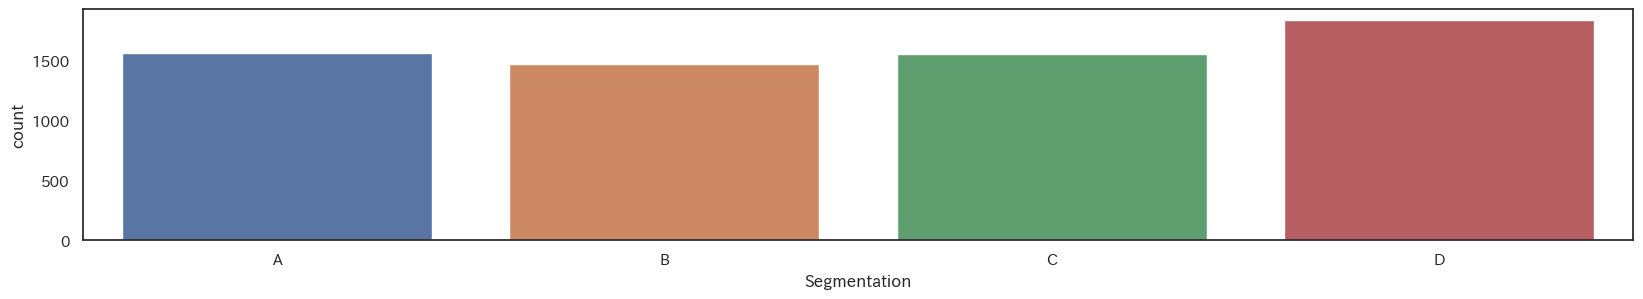

In [5]:
# Segmentation

#df['Segmentation'] = df['Segmentation'].replace(['A', 'B', 'C', 'D'], [1, 0, 0, 0])
display(df.groupby('Segmentation')['Segmentation'].count())

fig, ax = plt.subplots(figsize=(20,3))
sns.countplot(data=df, x='Segmentation', order=['A', 'B', 'C', 'D'])

# 二値問題の場合は、最初にSegmentationをreplaceしてやる。
# そのあとのチューニングは今回やっていないがポジティブ予測も含めてベースライン並みの数値は出るので改善余地があるかもしれない
# Bが少し少なく、Dが多い

Segmentation                
Segmentation            A    B    C     D
Gender                                   
Female                723  682  713   773
Male                  848  798  847  1070

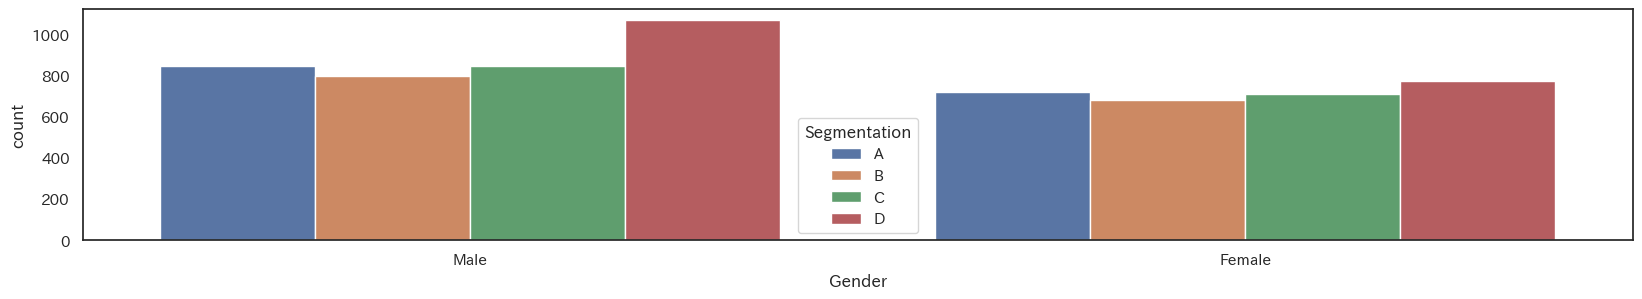

In [6]:
# Gender

fig, ax = plt.subplots(figsize=(20,3))
sns.countplot(data=df, x='Gender', hue='Segmentation', hue_order=['A', 'B', 'C', 'D'])

df.groupby(['Gender', 'Segmentation'])[['Segmentation']].count().unstack()

# 「あの」データセットはFemaleが多かったがこちらはMaleが多い
# この時点で既に、マニュピュレート（操作）された情報である疑いが濃厚と映る

Segmentation                  
Segmentation            A     B     C     D
Ever_Married                               
No                    640   382   315  1311
Yes                   902  1071  1224   493

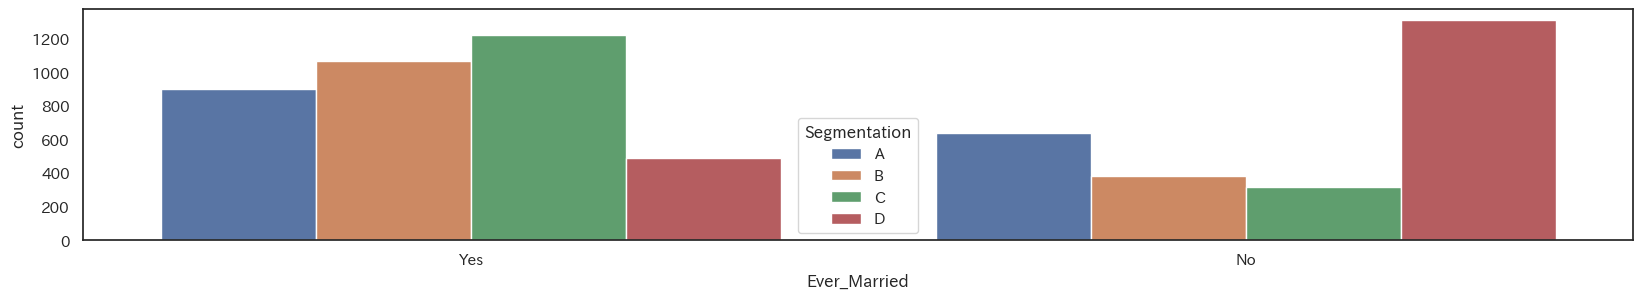

In [7]:
# Ever_Married

#df['Ever_Married'] = df['Ever_Married'].fillna('Unknown')

fig, ax = plt.subplots(figsize=(20,3))
sns.countplot(data=df, x='Ever_Married', hue='Segmentation', hue_order=['A', 'B', 'C', 'D'])

df.groupby(['Ever_Married', 'Segmentation'])[['Segmentation']].count().unstack()

# 欠損値は、コメントアウトしたコードを入れれば数値とグラフが描画される
# 解説動画では、要素間の違いが大きい欠損情報のみ特徴量としていたが、今回は違いがあれば全て情報として扱う方針とした

Age                         18   19  20  21   22  23  25  26  27  28  ...  80  \
             Segmentation                                             ...       
Segmentation A               2    6   3   2    6   1  49  45  46  56  ...   4   
             B               3    1   3   4    2   5  26  15  32  26  ...   2   
             C               2    5   4   6    3   7  24  13  29  29  ...   6   
             D             101  102  93  79  109  92  82  95  83  72  ...   6   

Age                        81  82  83  84  85  86  87  88  89  
             Segmentation                                      
Segmentation A              7  11   8  11   7   8  11  10  12  
             B             13   6   7   7   1   6   2   7   5  
             C              8   3   4   3   2   6   8   5   6  
             D              6   5   4   6   8   4   1   8   4  

[4 rows x 67 columns]

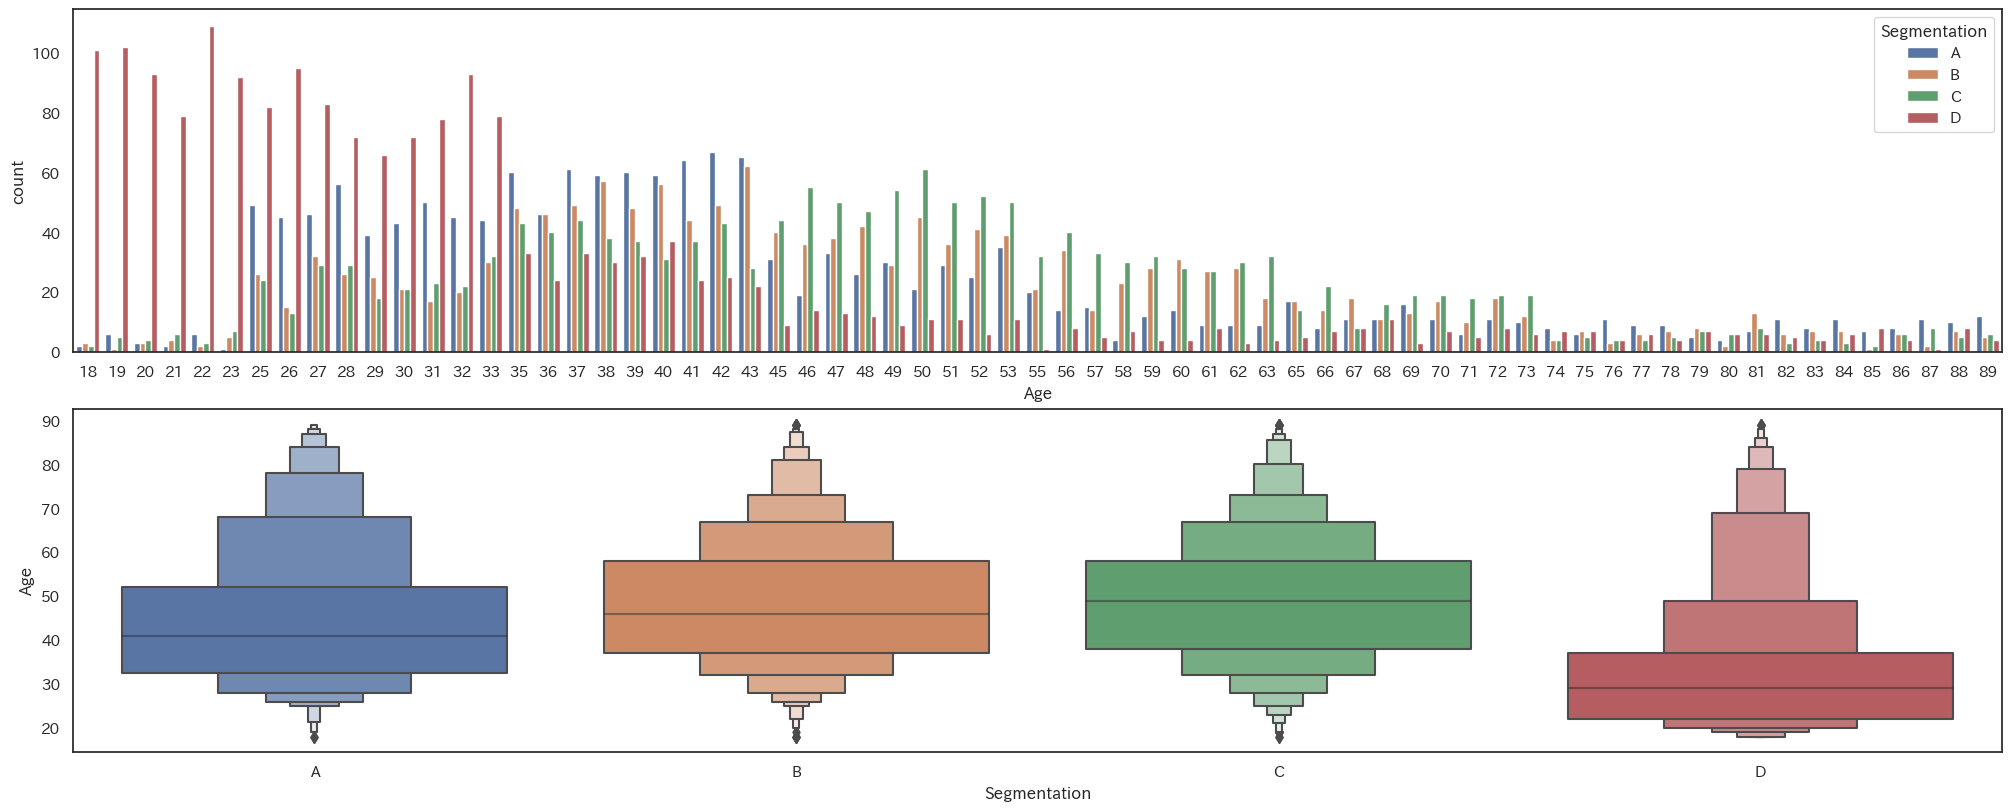

In [8]:
# Age

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,8), layout='constrained')
sns.countplot(data=df, x='Age', hue='Segmentation', hue_order=['A', 'B', 'C', 'D'], ax=ax1)
sns.boxenplot(data=df, x='Segmentation', y='Age', order=['A', 'B', 'C', 'D'], ax=ax2)

df.groupby(['Age', 'Segmentation'])[['Segmentation']].count().unstack().T

# Ageは、年齢と意味付ければこのまま連続値（実際は離散値）として扱うべきかもしれない
# しかし、各年齢のつぶつぶにもセグメンテーション情報があり、最終的にOne-hotエンコーディングでバラバラにして独立に扱うこととした
# 結果、ほとんどゼロしかない「疎な特徴量」に変換されるが、それは画像情報などと同じで分類器は「疎」な情報も実は扱える

Segmentation                  
Segmentation            A     B     C     D
Graduated                                  
No                    587   408   276  1165
Yes                   967  1057  1272   664

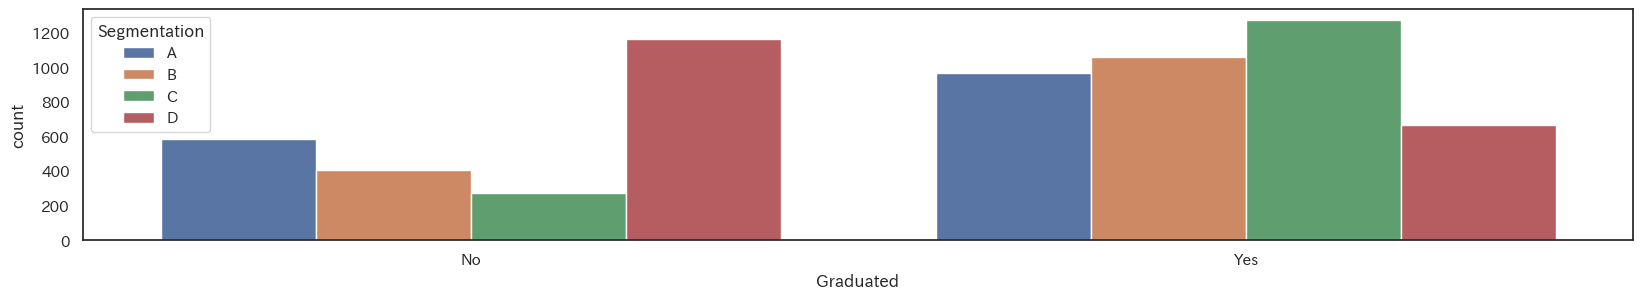

In [9]:
# Graduated

#df['Graduated'] = df['Graduated'].fillna('Unknown')

fig, ax = plt.subplots(figsize=(20,3))
sns.countplot(data=df, x='Graduated', hue='Segmentation', hue_order=['A', 'B', 'C', 'D'])

df.groupby(['Graduated', 'Segmentation'])[['Segmentation']].count().unstack()

# 全般にBは数も少なく、且つ、際立った特徴を持たない。
# 予測の混合行列を見ても、ほとんど当てられていない。
# 予測性能の高いモデルは、結果的にBを実際の割合よりも少なく分類することでBの曖昧さを回避している

Profession                 Artist  Doctor  Engineer  Entertainment  Executive  \
             Segmentation                                                       
Segmentation A                432     155       203            297        103   
             B                595     111       151            184        152   
             C                845     111        61            114        149   
             D                108     170       145            173         96   

Profession                 Healthcare  Homemaker  Lawyer  Marketing  
             Segmentation                                            
Segmentation A                     84         61     161         48  
             B                     85         45     119         20  
             C                    109         17     106         33  
             D                    804         74     105        129

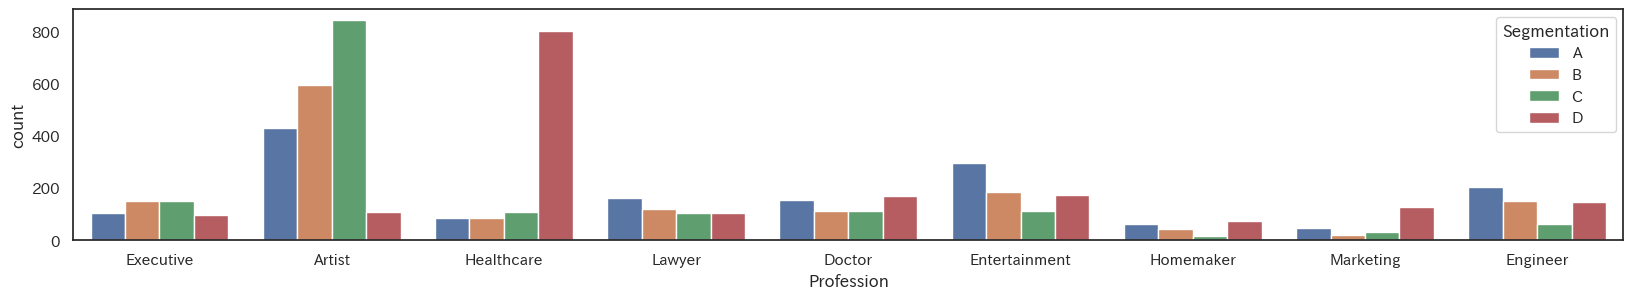

In [10]:
# Profession

#df['Profession'] = df['Profession'].fillna('Unknown')

fig, ax = plt.subplots(figsize=(20,3))
sns.countplot(data=df, x='Profession', hue='Segmentation', hue_order=['A', 'B', 'C', 'D'])

df.groupby(['Profession', 'Segmentation'])[['Segmentation']].count().unstack().T

# この職業分布をみて、数値は変えてあるが「あの」データセットと出どころが同じと確信する
# また、「変えてある」ところもミソ。
# これらの職業名はここに出ている「人数」以外の別の情報を豊富に含んでいるが、手が加えられているならその想定は障害にしかならないと分かる

Work_Experience            0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   \
             Segmentation                                                   
Segmentation A              442   457    53    44    44    41    38    39   
             B              446   450    49    51    49    33    35    32   
             C              487   508    61    49    59    29    40    38   
             D              486   474    62    61    50    52    53    44   

Work_Experience            8.0   9.0   10.0  11.0  12.0  13.0  14.0  
             Segmentation                                            
Segmentation A               95   106     9    14    15     9    11  
             B               69    74     7     7     8     7     5  
             C               77    65     7     6     2     4     2  
             D              134   128    19    13     8    11    13

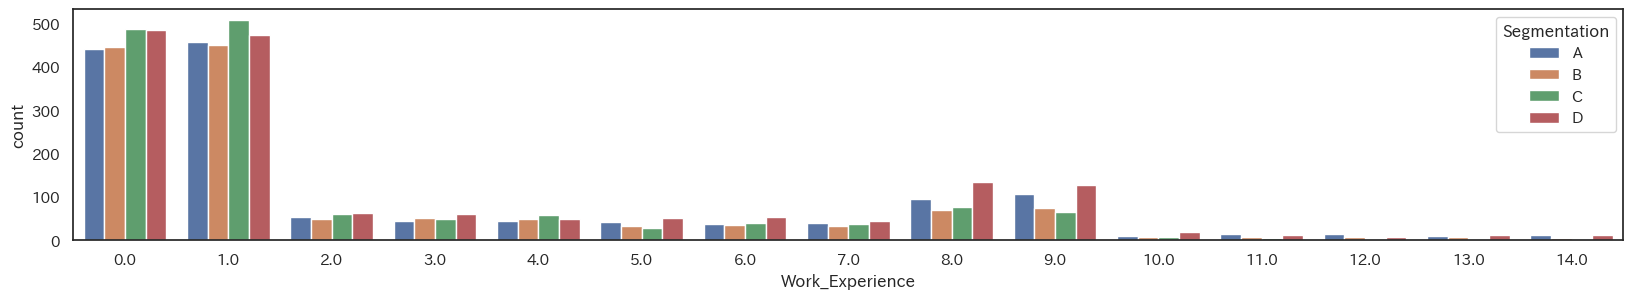

In [11]:
# Work_Experience

#df['Work_Experience'] = df['Work_Experience'].fillna('Unknown')

fig, ax = plt.subplots(figsize=(20,3))
sns.countplot(data=df, x='Work_Experience', hue='Segmentation', hue_order=['A', 'B', 'C', 'D'])

df.groupby(['Work_Experience', 'Segmentation'])[['Segmentation']].count().unstack().T

# 「あの」データセットと同じく、ほとんどのひとの職歴が極端に短い。欧米であってもリアルには有り得ない

Segmentation                
Segmentation              A    B    C     D
Spending_Score                             
Average                 280  488  716   103
High                    222  307  325   127
Low                    1069  685  519  1613

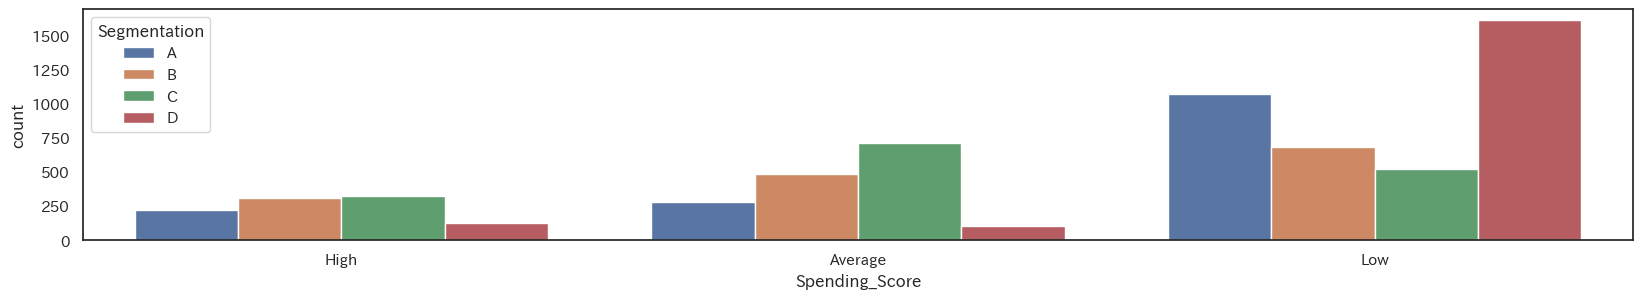

In [12]:
# Spending_Score

fig, ax = plt.subplots(figsize=(20,3))
sns.countplot(data=df, x='Spending_Score', hue='Segmentation', hue_order=['A', 'B', 'C', 'D'])

df.groupby(['Spending_Score', 'Segmentation'])[['Segmentation']].count().unstack()

# 「あの」データセットでは数値化されていたが、ここでは3段階表示になっている


Family_Size                1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0
             Segmentation                                             
Segmentation A             449  502  235  178   74   27   18    7    8
             B             282  493  259  246  113   34   10    5    3
             C             109  598  306  327  120   36   10    9    9
             D             325  291  379  380  204   80   33   19   12

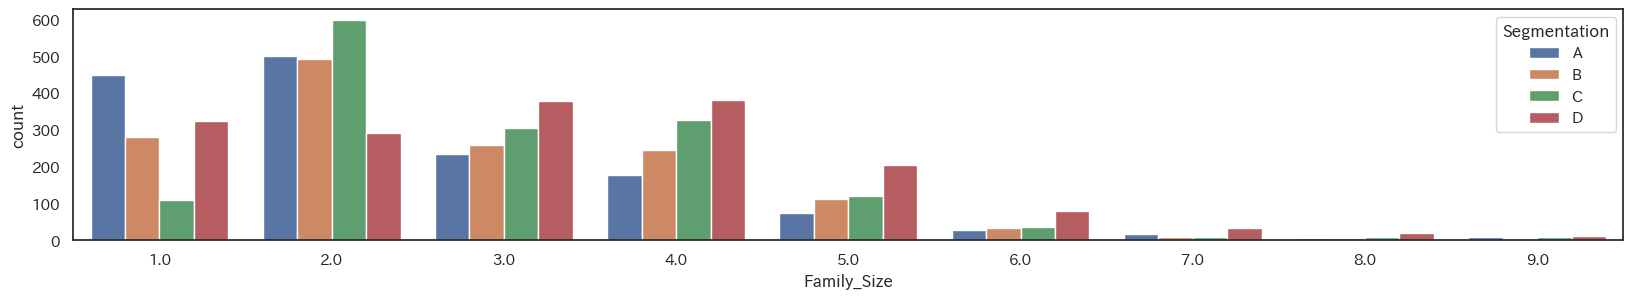

In [13]:
# Family_Size

#df['Family_Size'] = df['Family_Size'].fillna('Unknown')

fig, ax = plt.subplots(figsize=(20,3))
sns.countplot(data=df, x='Family_Size', hue='Segmentation', hue_order=['A', 'B', 'C', 'D'])

df.groupby(['Family_Size', 'Segmentation'])[['Segmentation']].count().unstack().T

# Family_Sizeもこちらはリアルを意識した階段状になっている
# これは元の数字に近いイメージだが本当はもっと独身が多いはず（などと考えるのは無駄ということ）

Var_1                      Cat_1  Cat_2  Cat_3  Cat_4  Cat_5  Cat_6  Cat_7
             Segmentation                                                 
Segmentation A                26     64    165    256     15    989     39
             B                23     81    155    187     15    976     31
             C                22     82    124     85     17   1176     37
             D                42    104    197    338     23   1070     53

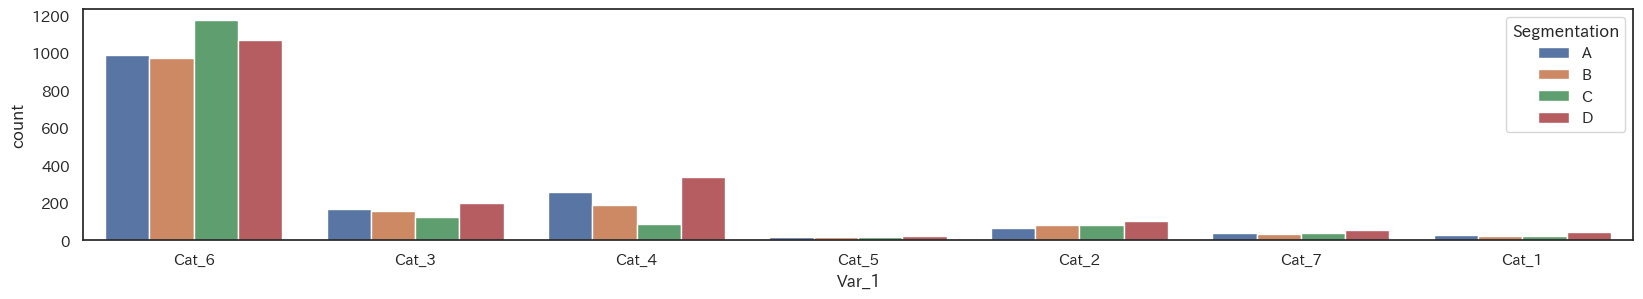

In [14]:
# Var_1

#df['Var_1'] = df['Var_1'].fillna('Unknown')

fig, ax = plt.subplots(figsize=(20,3))
sns.countplot(data=df, x='Var_1', hue='Segmentation', hue_order=['A', 'B', 'C', 'D'])

df.groupby(['Var_1', 'Segmentation'])[['Segmentation']].count().unstack().T

# カテゴリ名も伏せられたこの特徴量は、ある意味「ヒント」になっている
# つまり、「特徴量のラベルには意味がない」ことを示唆しているともとれる（製作者の意図は不明だが）

## 特徴量エンジニアリング

#### 特徴量追加（ラベルに意味がない以上、意味など考えず特徴量になりうるものはなんでも追加してみる）

In [15]:
# 欠損値特徴量列 Null

df['Null_P'] = df.apply(lambda x: 1 if x[['Profession']].isnull().any() else 0, axis=1)
df_test['Null_P'] = df_test.apply(lambda x: 1 if x[['Profession']].isnull().any() else 0, axis=1)

df['Null_W'] = df.apply(lambda x: 1 if x[['Work_Experience']].isnull().any() else 0, axis=1)
df_test['Null_W'] = df_test.apply(lambda x: 1 if x[['Work_Experience']].isnull().any() else 0, axis=1)

df['Null_F'] = df.apply(lambda x: 1 if x[['Family_Size']].isnull().any() else 0, axis=1)
df_test['Null_F'] = df_test.apply(lambda x: 1 if x[['Family_Size']].isnull().any() else 0, axis=1)

df['Null_E'] = df.apply(lambda x: 1 if x[['Ever_Married']].isnull().any() else 0, axis=1)
df_test['Null_E'] = df_test.apply(lambda x: 1 if x[['Ever_Married']].isnull().any() else 0, axis=1)

df['Null_G'] = df.apply(lambda x: 1 if x[['Graduated']].isnull().any() else 0, axis=1)
df_test['Null_G'] = df_test.apply(lambda x: 1 if x[['Graduated']].isnull().any() else 0, axis=1)

df['Null_V'] = df.apply(lambda x: 1 if x[['Var_1']].isnull().any() else 0, axis=1)
df_test['Null_V'] = df_test.apply(lambda x: 1 if x[['Var_1']].isnull().any() else 0, axis=1)

# Nullであるという情報は全て刻んで別々に取得する
# ほとんど横一線のものもあるがそれも情報の一部と考える

In [16]:
# 特徴量 A
df['A'] = df.apply(lambda x: 1 if (x['Family_Size'] == 1)
                                 | (x['Family_Size'] == 2)\
                             else 0, axis=1)
df_test['A'] = df_test.apply(lambda x: 1 if (x['Family_Size'] == 1)
                                           | (x['Family_Size'] == 2)\
                                       else 0, axis=1)

# 以下、一応、各々のカテゴリの境界を示すようなデータの纏まりにフラグ情報を追加した

In [17]:
# 特徴量 B
df['B'] = df.apply(lambda x: 1 if (x['Age'] >= 35)
                                 & (x['Age'] <= 43)\
                             else 0, axis=1)
df_test['B'] = df_test.apply(lambda x: 1 if (x['Age'] >= 35)
                                 & (x['Age'] <= 43)\
                             else 0, axis=1)

In [18]:
# 特徴量 C
df['C'] = df.apply(lambda x: 1 if (x['Age'] >= 45)
                                 & (x['Age'] <= 73)\
                             else 0, axis=1)
df_test['C'] = df_test.apply(lambda x: 1 if (x['Age'] >= 45)
                                 & (x['Age'] <= 73)\
                             else 0, axis=1)

In [19]:
# 特徴量 D
df['D'] = df.apply(lambda x: 1 if (x['Spending_Score'] == 'Low')
                                & ((x['Family_Size'] >= 3)\
                                | (x['Family_Size'] <= 6))\
                             else 0, axis=1)
df_test['D'] = df_test.apply(lambda x: 1 if (x['Spending_Score'] == 'Low')
                                         & ((x['Family_Size'] >= 3)\
                                          | (x['Family_Size'] <= 6))\
                                       else 0, axis=1)

In [20]:
df.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation', 'Null_P', 'Null_W', 'Null_F', 'Null_E', 'Null_G',
       'Null_V', 'A', 'B', 'C', 'D'],
      dtype='object')

In [21]:
# 欠損値補完準備（一旦、ラベルエンコーディングで数値に変換）

df['Gender'] = df['Gender'].replace(['Male', 'Female'], [0, 1])
df_test['Gender'] = df_test['Gender'].replace(['Male', 'Female'], [0, 1])
df['Spending_Score'] = df['Spending_Score'].replace(['High', 'Average', 'Low'], [0, 1, 2])
df_test['Spending_Score'] = df_test['Spending_Score'].replace(['High', 'Average', 'Low'], [0, 1, 2])
df['Graduated'] = df['Graduated'].replace(['Yes', 'No'], [0, 1])
df_test['Graduated'] = df_test['Graduated'].replace(['Yes', 'No'], [0, 1])

df['Ever_Married'] = df['Ever_Married'].replace(['Yes', 'No'], [0, 1])
df_test['Ever_Married'] = df_test['Ever_Married'].replace(['Yes', 'No'], [0, 1])
df['Var_1'] = df['Var_1'].replace(['Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5', 'Cat_6', 'Cat_7'],
                                            [1, 2, 3, 4, 5, 6, 7])
df_test['Var_1'] = df_test['Var_1'].replace(['Cat_1', 'Cat_2', 'Cat_3', 'Cat_4', 'Cat_5', 'Cat_6', 'Cat_7'],
                                                      [1, 2, 3, 4, 5, 6, 7])
df['Profession'] = df['Profession'].replace(['Executive', 'Artist', 'Healthcare', 'Lawyer', 'Doctor',
       'Entertainment', 'Homemaker', 'Marketing', 'Engineer'], [0, 1, 2, 3, 4, 5, 6, 7, 8])
df_test['Profession'] = df_test['Profession'].replace(['Executive', 'Artist', 'Healthcare', 'Lawyer', 'Doctor',
       'Entertainment', 'Homemaker', 'Marketing', 'Engineer'], [0, 1, 2, 3, 4, 5, 6, 7, 8])

# 機械学習で欠損値補完するので、全て数値化する

In [22]:
# 欠損値補完

cols = ['Graduated', 'Ever_Married', 'Var_1', 'Profession', 'Family_Size', 'Work_Experience']

for data in [df, df_test]:
    features = ['Gender', 'Age', 'Spending_Score']
    for col in cols:
        mask = data[col].isnull()
        masked_X = data.loc[~mask, features]
        masked_y = data.loc[~mask, col]
        masked_X_test = data.loc[mask, features]
        lgb_model = lgb.LGBMClassifier()
        lgb_model = OneVsOneClassifier(lgb_model).fit(masked_X, masked_y)
        data.loc[mask, col] = lgb_model.predict(masked_X_test)
        features.append(col)

# 「データに欠損のないGender, Age, Spending_Scoreを使って予測で埋める」ということをやってみる
# さらに、「予測したデータを継ぎ足しながら予測する」というのもやってみる
# 試行錯誤の結果、ここではLightGBMをOnVsOne方式で分類するという組み合わせを採用
# どれほどの意味があるかは分からないが、あくまで試行錯誤結果としてはスコアに貢献していると思う
# なお、予測の順番はcolsの順番なので、ここを変えると結果が少しずつ変わる

In [23]:
display(df.info())
display(df_test.info())
display(df)
display(df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454 entries, 0 to 6453
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               6454 non-null   int64  
 1   Gender           6454 non-null   int64  
 2   Ever_Married     6454 non-null   float64
 3   Age              6454 non-null   int64  
 4   Graduated        6454 non-null   float64
 5   Profession       6454 non-null   float64
 6   Work_Experience  6454 non-null   float64
 7   Spending_Score   6454 non-null   int64  
 8   Family_Size      6454 non-null   float64
 9   Var_1            6454 non-null   float64
 10  Segmentation     6454 non-null   object 
 11  Null_P           6454 non-null   int64  
 12  Null_W           6454 non-null   int64  
 13  Null_F           6454 non-null   int64  
 14  Null_E           6454 non-null   int64  
 15  Null_G           6454 non-null   int64  
 16  Null_V           6454 non-null   int64  
 17  A             

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1614 entries, 0 to 1613
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               1614 non-null   int64  
 1   Gender           1614 non-null   int64  
 2   Ever_Married     1614 non-null   float64
 3   Age              1614 non-null   int64  
 4   Graduated        1614 non-null   float64
 5   Profession       1614 non-null   float64
 6   Work_Experience  1614 non-null   float64
 7   Spending_Score   1614 non-null   int64  
 8   Family_Size      1614 non-null   float64
 9   Var_1            1614 non-null   float64
 10  Null_P           1614 non-null   int64  
 11  Null_W           1614 non-null   int64  
 12  Null_F           1614 non-null   int64  
 13  Null_E           1614 non-null   int64  
 14  Null_G           1614 non-null   int64  
 15  Null_V           1614 non-null   int64  
 16  A                1614 non-null   int64  
 17  B             

None

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,...,Null_P,Null_W,Null_F,Null_E,Null_G,Null_V,A,B,C,D
0,463864,0,0.0,81,1.0,0.0,9.0,0,2.0,6.0,...,0,1,0,0,0,0,1,0,0,0
1,465025,0,0.0,73,0.0,0.0,0.0,0,2.0,6.0,...,0,0,0,0,0,0,1,0,1,0
2,461687,1,0.0,77,0.0,1.0,0.0,0,2.0,6.0,...,0,0,0,0,0,0,1,0,0,0
3,461646,1,0.0,60,0.0,1.0,1.0,0,4.0,6.0,...,0,1,0,0,0,0,0,0,1,0
4,459591,0,0.0,50,0.0,1.0,1.0,1,3.0,6.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6449,466126,1,0.0,57,1.0,8.0,0.0,2,1.0,6.0,...,0,0,0,0,0,0,1,0,1,1
6450,460859,0,0.0,50,0.0,5.0,0.0,2,4.0,6.0,...,0,1,0,0,0,0,0,0,1,1
6451,464268,1,1.0,51,0.0,1.0,0.0,2,1.0,6.0,...,0,0,0,0,0,0,1,0,1,1
6452,465754,1,0.0,57,0.0,1.0,0.0,1,4.0,6.0,...,0,0,0,0,0,0,0,0,1,0


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Null_P,Null_W,Null_F,Null_E,Null_G,Null_V,A,B,C,D
0,461642,0,1.0,41,0.0,1.0,9.0,2,2.0,6.0,0,0,0,0,0,0,1,1,0,1
1,462489,0,0.0,46,0.0,1.0,0.0,2,2.0,6.0,0,0,0,0,0,0,1,0,1,1
2,459573,0,0.0,70,1.0,3.0,0.0,2,1.0,6.0,0,1,0,0,0,0,1,0,1,1
3,461424,0,0.0,63,1.0,2.0,0.0,1,4.0,4.0,0,0,0,0,0,0,0,0,1,0
4,460283,0,0.0,43,0.0,4.0,14.0,2,2.0,6.0,0,0,0,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,465156,0,0.0,46,0.0,1.0,1.0,1,5.0,6.0,0,1,0,0,0,0,0,0,1,0
1610,459836,0,0.0,32,0.0,2.0,8.0,0,5.0,7.0,0,0,0,1,0,0,0,0,0,0
1611,462705,1,0.0,69,1.0,3.0,0.0,1,2.0,6.0,0,0,0,0,0,0,1,0,1,0
1612,461834,1,1.0,42,0.0,1.0,7.0,2,2.0,6.0,0,0,0,0,0,0,1,1,0,1


In [24]:
# One-hotエンコーディング

df = pd.get_dummies(data=df,
                    columns=['Gender', 'Ever_Married', 'Graduated', 'Age', 'Work_Experience',
                             'Profession', 'Spending_Score', 'Family_Size', 'Var_1'],
                    drop_first=True)
df_test = pd.get_dummies(data=df_test,
                         columns=['Gender', 'Ever_Married', 'Graduated', 'Age', 'Work_Experience',
                                  'Profession', 'Spending_Score', 'Family_Size', 'Var_1'],
                         drop_first=True)

# 一旦、ラベルエンコードしたものも含めて全て1，0情報に変換してしまう

In [25]:
display(df.info())
display(df_test.info())
display(df)
display(df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6454 entries, 0 to 6453
Columns: 119 entries, ID to Var_1_7.0
dtypes: int64(11), object(1), uint8(107)
memory usage: 1.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1614 entries, 0 to 1613
Columns: 118 entries, ID to Var_1_7.0
dtypes: int64(11), uint8(107)
memory usage: 307.5 KB


None

,ID,Segmentation,Null_P,Null_W,Null_F,Null_E,Null_G,Null_V,A,B,...,Family_Size_6.0,Family_Size_7.0,Family_Size_8.0,Family_Size_9.0,Var_1_2.0,Var_1_3.0,Var_1_4.0,Var_1_5.0,Var_1_6.0,Var_1_7.0
0,463864,B,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,465025,C,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,461687,B,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,461646,C,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,459591,C,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6449,466126,B,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
6450,460859,D,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6451,464268,A,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
6452,465754,C,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


,ID,Null_P,Null_W,Null_F,Null_E,Null_G,Null_V,A,B,C,...,Family_Size_6.0,Family_Size_7.0,Family_Size_8.0,Family_Size_9.0,Var_1_2.0,Var_1_3.0,Var_1_4.0,Var_1_5.0,Var_1_6.0,Var_1_7.0
0,461642,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
1,462489,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
2,459573,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3,461424,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,460283,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,465156,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1610,459836,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1611,462705,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1612,461834,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0


logistic_model
    accuracy_ave.: 0.522
SVC_model
    accuracy_ave.: 0.537
RFC_model
    accuracy_ave.: 0.508
lgb_model
    accuracy_ave.: 0.525


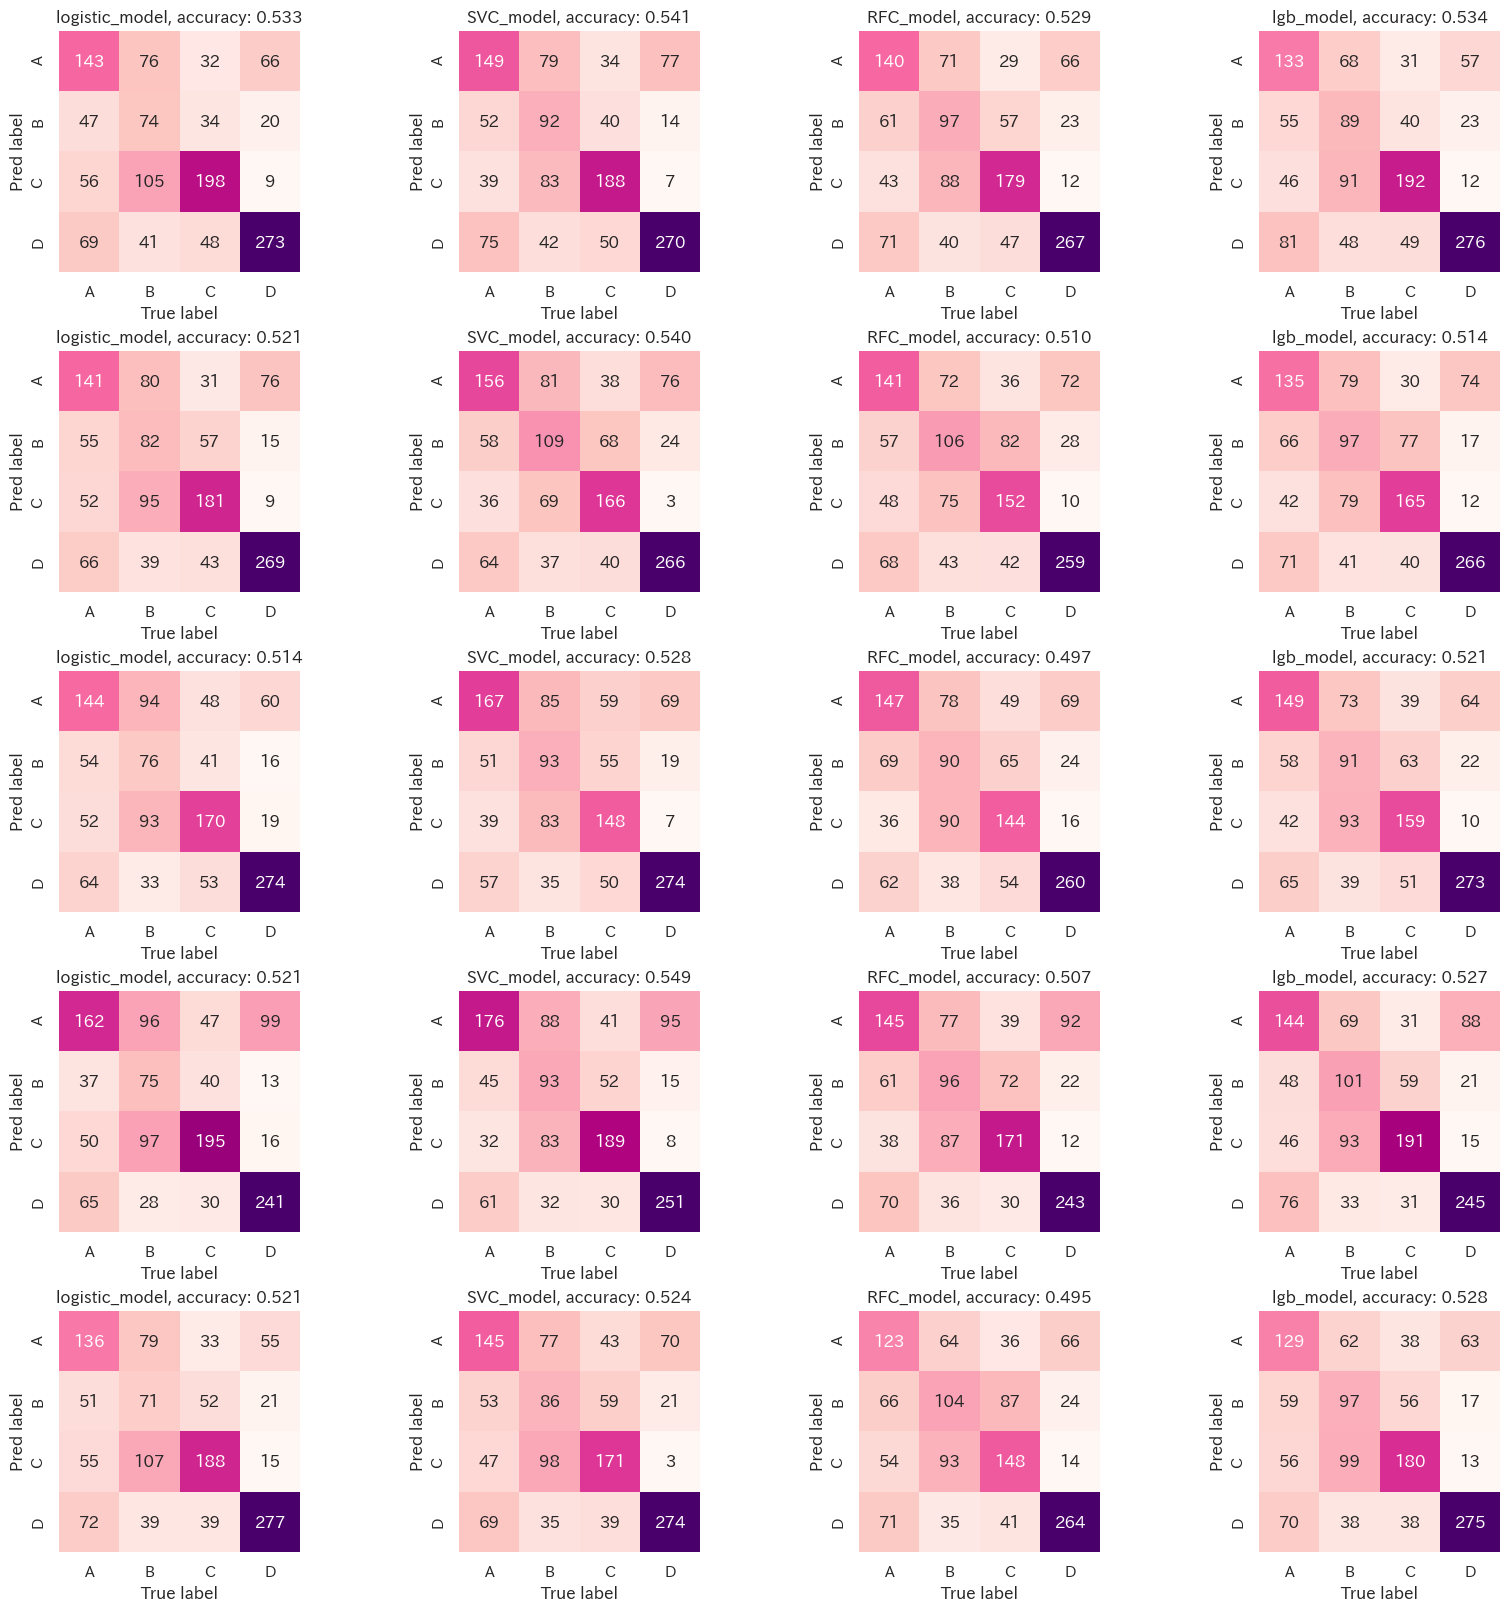

In [26]:
# クロスバリデーション

skf = StratifiedKFold(n_splits=5, shuffle=True,)# random_state=42)

X = df.drop(columns=['ID', 'Segmentation'])
y = df.Segmentation

# 分類器４種
models = {'logistic_model':LogisticRegression(C=0.1),
          'SVC_model':SVC(),
          'RFC_model':ensemble.RandomForestClassifier(),
          'lgb_model':lgb.LGBMClassifier()}
dic_scores = defaultdict(list)

fig, ax = plt.subplots(5, 4, figsize=(16, 16), layout='constrained')
for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    for j, (name, model) in enumerate(models.items()):
        X_train, X_test = X.loc[train_idx,:], X.loc[test_idx,:]
        y_train, y_test = y[train_idx], y[test_idx]
        # 予測（One vs One）
        model = OneVsOneClassifier(model).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # 評価
        score = accuracy_score(y_test, y_pred)
        dic_scores[name].append(score)
        # 混合行列描画
        mat = confusion_matrix(y_test, y_pred)
        sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            xticklabels=['A', 'B', 'C', 'D'], yticklabels=['A', 'B', 'C', 'D'],
            cmap='RdPu', cbar=False, ax=ax[i, j])
        ax[i, j].set_xlabel('True label')
        ax[i, j].set_ylabel('Pred label')
        ax[i, j].set_title(f'{name}, accuracy: {score:.3f}')

for name in models.keys():
    print(f'{name}\n    accuracy_ave.: {sum(dic_scores[name]) / 5:.3f}')

# ここで徹底的にシミュレーションを行い、どういったデータの持ち方がスコアにどう影響するかを確認した
# Logistic回帰が意外と健闘している
# LightGBMが安定しているが、最適かというと必ずしもそうではない
# SVCは一定以上データに偏りがあると極端に偏った予測を返すので取り扱いが難しかった
# 但し、クロスバリデーションをStratifiedKFoldとし、データをOne-hotで刻んだら頭一つ抜きんでた形
# 限界的な数値改善には私も含めて否定的な人が多いと思うが、こういった取り組みがモデルの性格を知るよい機会であることも事実